In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from scipy import stats
import warnings
from TESStools import *
from tqdm.notebook import tqdm

In [2]:
fyps = pd.read_csv('fyps.csv')
this_star = fyps[fyps['CommonName'] == 'HD 269953']
this_star

,CommonName,ContRatio,Dec,Dec_y,MKType,MatchID,RA,RA_y,SimbadOType,SimbadSpT,...,w3mag,w4mag,alpha,e_alpha,tau,e_tau,gamma,e_gamma,alpha_w,e_alpha_w
0,HD 269953,NaN,-69.668015,NaN,G0,404850274,85.050696,NaN,YellowSG*,G0_0,...,4.063,1.214,0.015843,0.000705,0.428785,0.024308,1.527786,0.027423,0.001731,7.293427e-07


In [13]:
#prewhitening
tic = this_star['TIC ID'][0]
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
print(1.0/(time.max() - time.min()))
good_fs, good_amps, good_phases, good_snrs, good_peaks = prewhiten(time, flux, err)
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
freq, power = LombScargle(time, flux, dy=err).autopower(normalization='psd')
power /= len(time)
popt, pcov, resid = fit_red_noise(freq, power)

0.0028006421838841517
10
Found 10 frequencies
10 unique frequencies


In [4]:
for f,s in zip(good_fs,good_snrs):
    print(f[0],s)

1.5934882383143154 53.83209987245968
2.6704300166178965 32.743371305656254
1.3352284657601756 20.208048534666144
1.1741871519576779 29.419004250982344
4.005715817614458 17.189470716360876
3.1869150781283277 28.32884722309755
4.780276936915193 40.24658763155845
5.341245822333371 24.721480060063527
2.3486007257770054 21.93738122358371
2.572940689885986 21.24829546959944


In [5]:
good_fs[:,0]

array([1.59348824, 2.67043002, 1.33522847, 1.17418715, 4.00571582,
       3.18691508, 4.78027694, 5.34124582, 2.34860073, 2.57294069])

In [6]:
ls_dict = {0:'-',1:'--',2:'-.',3:':'}

[1.59348824 1.59348824 1.33522847 1.33522847 1.33522847] [3.18691508 4.78027694 2.67043002 4.00571582 5.34124582] [2. 3. 2. 3. 4.]


/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/carina/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


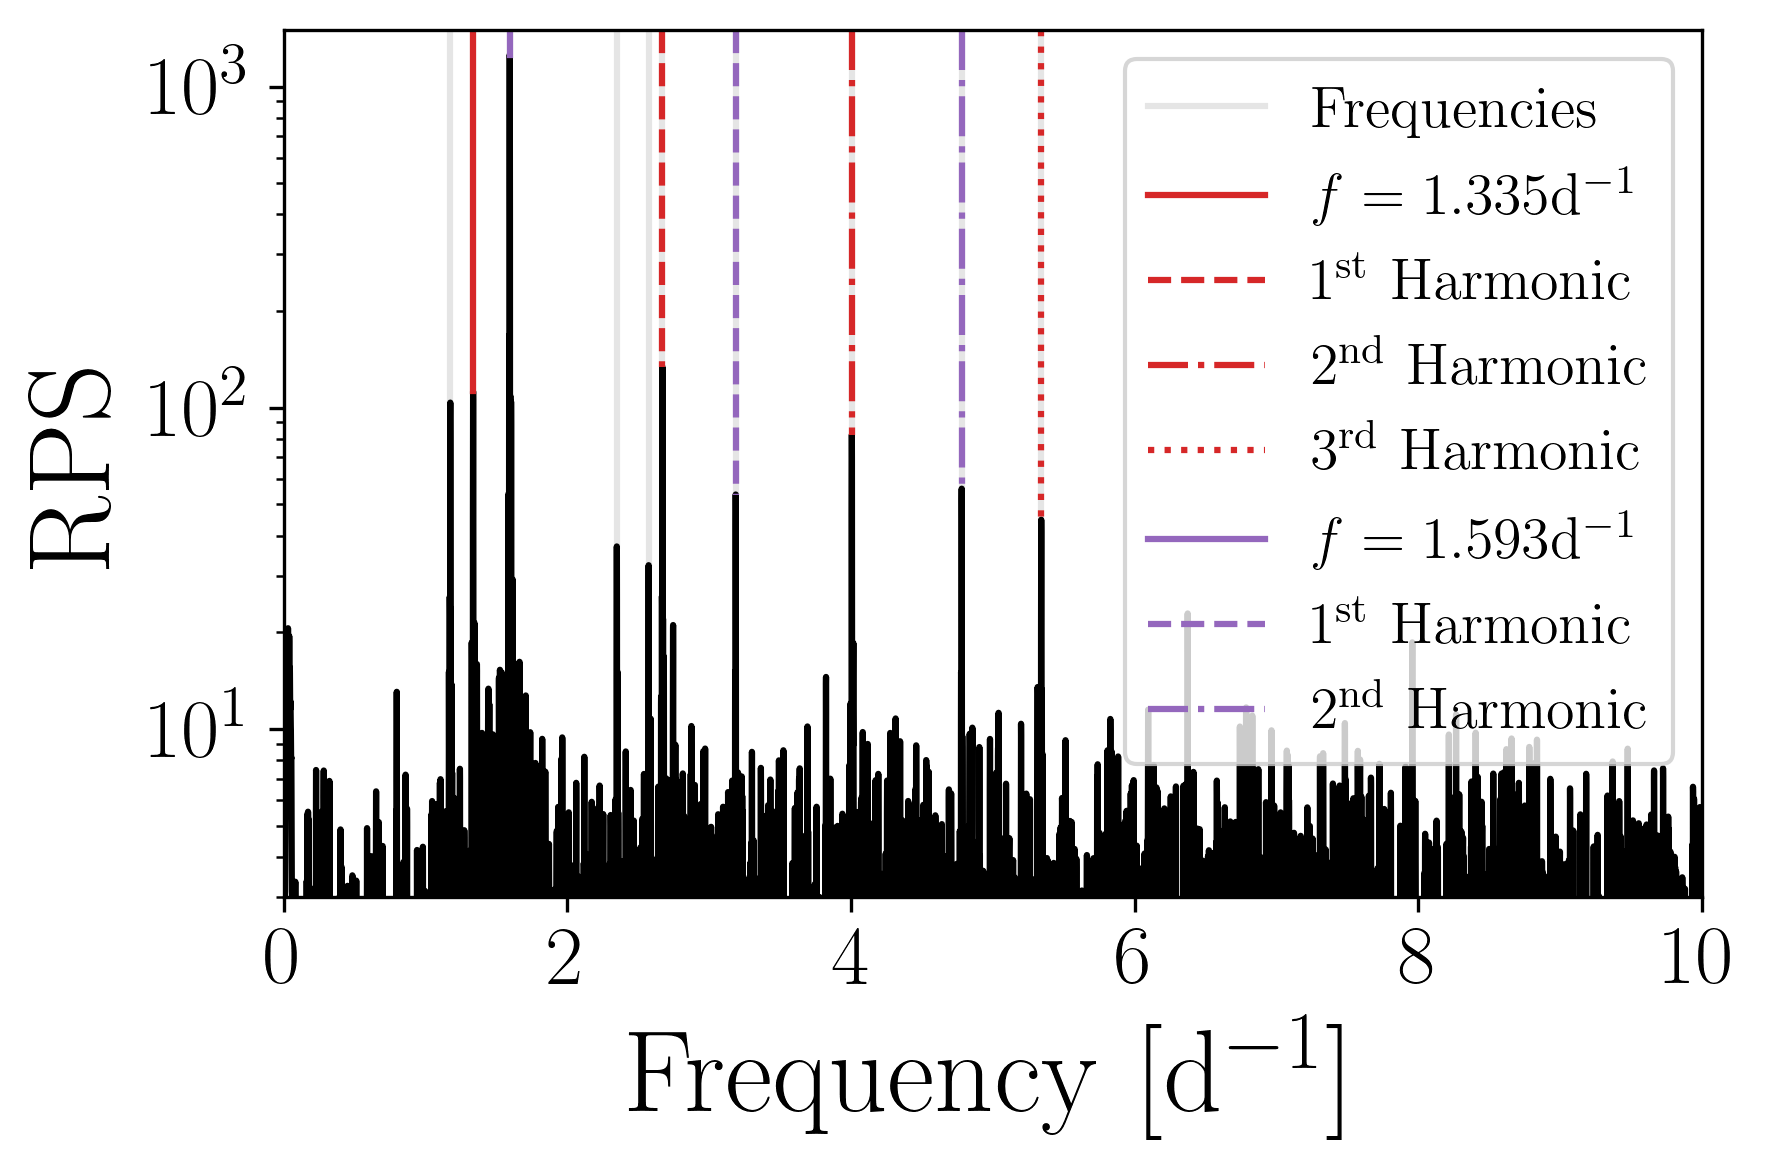

In [7]:
fig = plt.figure(dpi=300)
plt.semilogy(freq, resid,c='k')

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]', ylabel='RPS', xlim=(0,10),ylim=(3,1500))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],resid[np.argmin(np.abs(freq-good_fs[0,0]))]],alpha=0.1,c='k',label='Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],resid[np.argmin(np.abs(freq-f))]],c='k',alpha=0.1)

funds, overs, degs = harmonic_search(good_fs)
print(funds,overs,degs)
for num,f in enumerate(np.unique(funds)):
    c = f'C{num+3}'
    plt.plot([f,f],[ylim[1],resid[np.argmin(np.abs(freq-f))]],c=c,ls=ls_dict[0],label=f'$f={f:.3f}$'+'d$^{-1}$')
    this_over = overs[funds == f]
    this_deg = degs[funds == f]
    for ov, de in zip(this_over, this_deg):
        if de-1 == 1:
            th = 'st'
        elif de-1 == 2:
            th = 'nd'
        elif de-1 == 3:
            th = 'rd'
        else:
            th='th'
        plt.plot([ov,ov],[ylim[1],resid[np.argmin(np.abs(freq-ov))]],c=c,ls=ls_dict[de-1],label = f'{int(de-1)}'+r'$^{\rm '+ th+'}$ Harmonic')
        
ax.set_ylim(ylim)
leg = ax.legend(fontsize=14)
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.tight_layout()
plt.savefig('../plots/hd269953_frequencies.pdf')

In [8]:
combo_search(good_fs)

array([[1.59348824, 2.67043002],
       [3.18691508, 1.33522847],
       [4.78027694, 4.00571582]])

In [9]:
2**5.5 / 2/np.pi

7.202530529256849

In [10]:
#WWZ wavelet fun
#Let's put our functions in a list that we can loop over
func_list = [phi_1,phi_2,phi_3]
f1 = phi_1 #we're also going to need this one explicitly later
#and finally a decay constant for the Gaussian envelope
c = 0.0125
y = flux.values
t = time.values
omega_start = -1 #log2(1/32)
omega_end = 5.5 #log2(16) 
omegas = np.logspace(omega_start,omega_end,1000,base=2)
taus = np.linspace(np.min(t),np.max(t),500)
wwz,wwa = MP_WWZ(func_list,f1,y,t,omegas,taus,c=c)

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


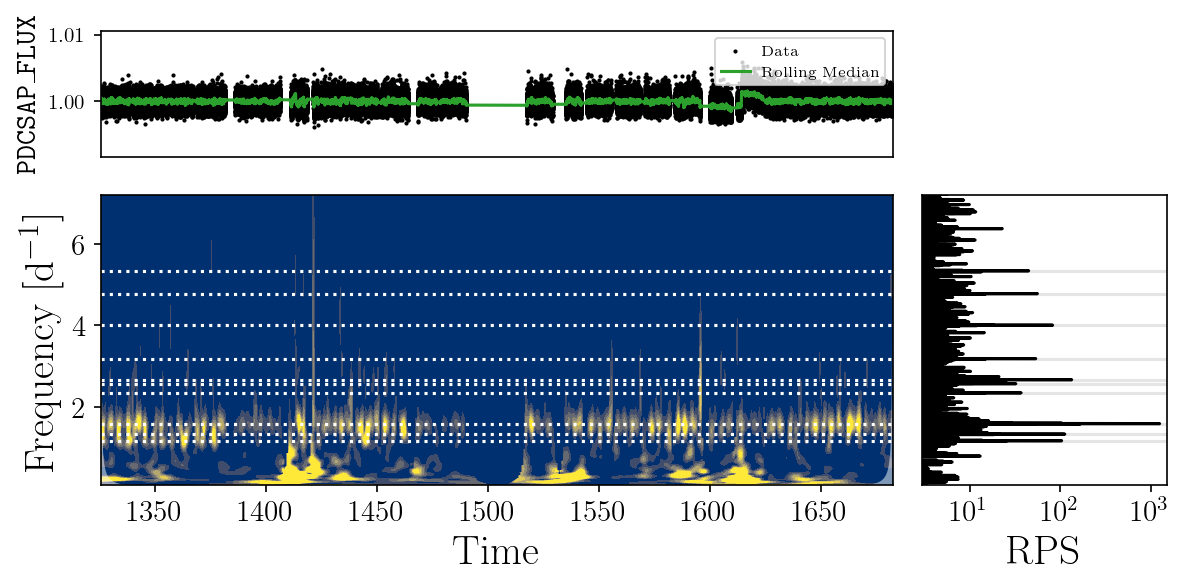

In [12]:
fig = plt.figure(constrained_layout=True,figsize=(8,4),dpi=150)

gs = GridSpec(3, 4, figure=fig)
lcax = fig.add_subplot(gs[0, :3])
wwzax = fig.add_subplot(gs[1:,:3])
zsumax = fig.add_subplot(gs[1:,3])

lcax.scatter(time,flux,s=1,c='k',label=r'Data',rasterized=True)
lcax.plot(lc_smooth['Time'],lc_smooth['Flux'],c='C2',label=r'Rolling Median',rasterized=True)
lcax.set(ylabel=r'$\mathrm{\tt PDCSAP\\\_FLUX}$',xlim=(np.min(time),np.max(time)),xticks=[])
h, l = lcax.get_legend_handles_labels()
lcax.legend(h[::-1],l[::-1],loc='upper right',fontsize='x-small')

wwzax.contourf(taus,omegas/2.0/np.pi,wwz,levels=100,cmap='cividis',vmax=50)
wwzax.fill_between(2*np.pi/omegas+np.min(t),0,omegas/2/np.pi,alpha=0.5,facecolor='white')
wwzax.fill_between(np.max(t)-2*np.pi/omegas,0,omegas/2/np.pi,alpha=0.5,facecolor='white')
wwzax.set(ylabel=r'Frequency [d$^{-1}$]',xlabel='Time',
          ylim=(np.min(omegas)/2/np.pi,np.max(omegas/2/np.pi)))



zsumax.semilogx(resid,freq,c='k',rasterized=True)
zsumax.set(yticks=[],xticks=[10,100,1000],xlabel=r'RPS',
           ylim=(np.min(omegas)/2/np.pi,np.max(omegas/2/np.pi)),
           xlim=(3,1500))
zs_lim = zsumax.get_xlim()
for f in good_fs[:,0]:
    wwzax.axhline(y=f,c='white',ls=':')
    zsumax.plot([zs_lim[1],resid[np.argmin(np.abs(freq-f))]],[f,f],c='k',alpha=0.1)
for ax in [lcax,wwzax,zsumax]:
    if ax == lcax:
        ax.xaxis.label.set_size(14)
        ax.yaxis.label.set_size(14)
    else:
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(14)
    plt.tight_layout()
plt.savefig('../plots/hd269953_wwz.pdf')